In [1]:
# Pour installer les packages
%pip install pandas
%pip install seaborn
%pip install matplotlib
%pip install numpy
%pip install sklearn
%pip install os
%pip install shutil
%pip install re


# pour importer les packages installer

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

import os
import shutil
import re


plt.style.use('ggplot')

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [2]:

#data=pd.read_csv("nom du fichier test",sep=";")

data=pd.read_csv("",sep=";")

def rendement(data):
    s0=data.shift(periods=1)
    s0[0]=s0[1]
    S_t= np.array(data)
    return (S_t-s0)/s0

def convertisseur_rendement(data):

    #met les données du prof au bon format.
    data["date 1"]=pd.to_datetime(data["date 1"],format='%m/%d/%Y')

    data["date 2"]=pd.to_datetime(data["date 2"],format='%m/%d/%Y')
    data["date 3"]=pd.to_datetime(data["date 3"],format='%m/%d/%Y')
    data["date 4"]=pd.to_datetime(data["date 4"],format='%m/%d/%Y')

    data1=data[['date 1','Actions US Value']].copy().set_index('date 1').rename_axis('date', axis=0)
    data2=data[['date 2','Actions US Growth']].copy().set_index('date 2').rename_axis('date', axis=0)
    data4=data[['date 4','Indice de reference']].copy().set_index('date 4').rename_axis('date', axis=0)
    data3=data[['date 3','Monetaire US']].copy().set_index('date 3').rename_axis('date', axis=0)

    data=pd.merge(data1, data2,on="date")
    data=pd.merge(data, data3,on="date")
    data=pd.merge(data, data4,on="date")
    data=data.resample('M').mean()
    
    #Appliquer la fonction rendement au données du prof pour convertir en rendement
    i=0
    for col in data.columns:
        if i==0:
            data_rendement=pd.DataFrame({col+"_rendement":rendement(data[col])},index=data.index)
            i+=1
        else:
            data_rendement=pd.merge(data_rendement,pd.DataFrame({col+"_rendement":rendement(data[col])},index=data.index),right_index=True,left_index=True,how='inner')
    
    
    # On va importe notre indicateur et nos poids
    
    indic_poids=pd.read_csv("indic_poids.csv")
    indic_poids["date"]=pd.to_datetime(indic_poids["date"],format='%Y/%m/%d')
    indic_poids=indic_poids.set_index('date')
    data=pd.merge(indic_poids,data_rendement,left_index=True, right_index=True,how='outer')
    data.to_csv('indicateur_poids_données_test.csv')
    #on calcule notre stratégie
    rendement_mensuel=pd.DataFrame({"rendement mensuel":np.array(data["poids_US_Monetaire"]).reshape(334)*np.array(data["Monetaire US_rendement"])+np.array(data['poids_Action_US_Growth']).reshape(334)*np.array(data["Actions US Growth_rendement"])+np.array(data['poids_Action_US_Value']).reshape(334)*np.array(data["Actions US Value_rendement"])},index=data.index)
    rendement_mensuel=pd.merge(rendement_mensuel,data_rendement['Indice de reference_rendement'],how='inner',left_index=True, right_index=True)
   
    return(rendement_mensuel)

resultat=convertisseur_rendement(data)
    

#exporte le fichier excel contenant le poids, l'indicateur,et les rendement du fichier ajouter.
resultat.to_csv("indicateur_vs_indicateur_de_reference.csv")

resultat

,rendement mensuel,Indice de reference_rendement
date,,
1995-06-30,NaN,0.000000
1995-07-31,NaN,0.023160
1995-08-31,NaN,0.003128
1995-09-30,NaN,0.035155
1995-10-31,NaN,0.007175
...,...,...
2018-08-31,0.001638,0.022973
2018-09-30,0.001643,0.015284
2018-10-31,0.001711,-0.039992


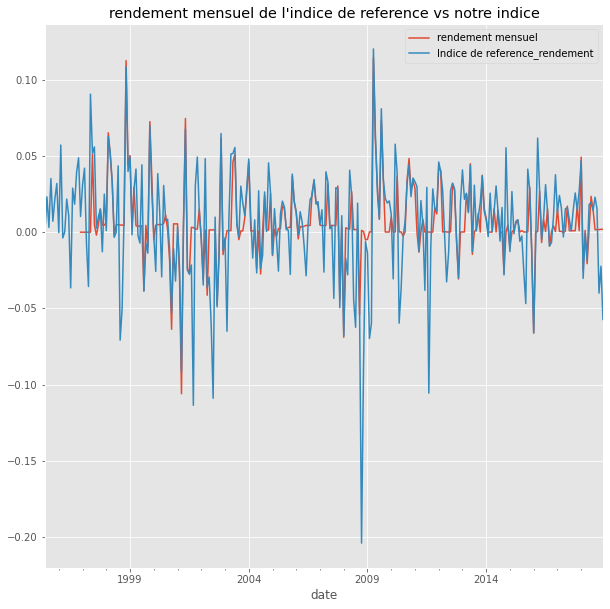

In [3]:
plt.figure(figsize=(10,10))
for col in ["rendement mensuel","Indice de reference_rendement"]:
    resultat[col].plot()
    plt.legend()
    plt.title("rendement mensuel de l'indice de reference vs notre indice")
plt.show()

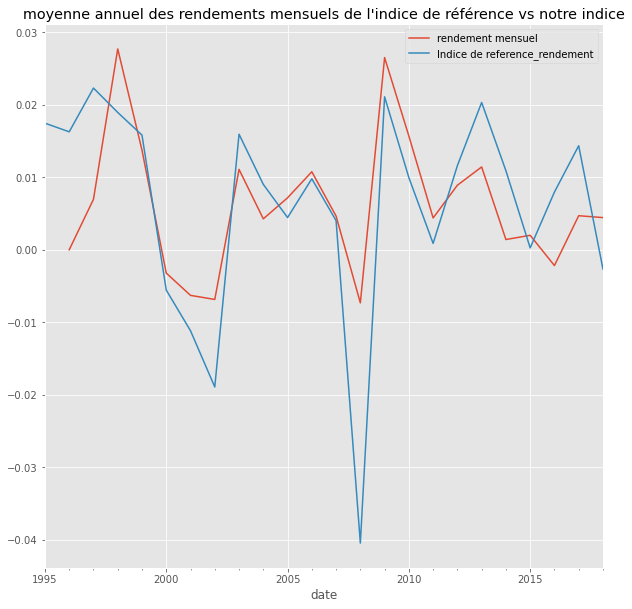

In [4]:
plt.figure(figsize=(10,10))
for col in ["rendement mensuel","Indice de reference_rendement"]:
    resultat[col].resample('Y').mean().plot()
    plt.legend()
    plt.title("moyenne annuel des rendements mensuels de l'indice de référence vs notre indice")

plt.show()

Certain des indicateurs journaliers sélectionné sont composé de plusieurs composantes. On va donc les aggréer 



In [5]:
########################## indicateur VIX

data_VIX=pd.read_csv("composite/^VIX.csv",sep=",")

data_VIX["date"]=pd.to_datetime(data_VIX["date"],format='%Y-%m-%d')
data_VIX=data_VIX.set_index('date')

#moyenne sur le mois
data_VIX=data_VIX.resample('M').mean()

# On aggrege les composites en faisant la moyenne sur les observations.
data_VIX=pd.DataFrame(data_VIX.mean(axis=1),columns=['VIX'])


########################## indicateur RUT
data_RUT=pd.read_csv("composite/^RUT.csv",sep=",")

data_RUT["date"]=pd.to_datetime(data_RUT["date"],format='%Y-%m-%d')
data_RUT=data_RUT.set_index('date')

#moyenne sur le mois
data_RUT=data_RUT.resample('M').mean()

# On aggrege les composites en faisant la moyenne sur les observations.
data_RUT=pd.DataFrame(data_RUT.mean(axis=1),columns=['RUT'])
data_RUT


########################## indicateur FCHI
data_FCHI=pd.read_csv("composite/^FCHI.csv",sep=",")

data_FCHI["date"]=pd.to_datetime(data_FCHI["date"],format='%Y-%m-%d')
data_FCHI=data_FCHI.set_index('date')

#moyenne sur le mois
data_FCHI=data_FCHI.resample('M').mean()

# On aggrege les composites en faisant la moyenne sur les observations.
data_FCHI=pd.DataFrame(data_FCHI.mean(axis=1),columns=['FCHI'])
data_FCHI



########################## indicateur HSI
data_HSI=pd.read_csv("composite/^HSI.csv",sep=",")

data_HSI["date"]=pd.to_datetime(data_HSI["date"],format='%Y-%m-%d')
data_HSI=data_HSI.set_index('date')

#moyenne sur le mois
data_HSI=data_HSI.resample('M').mean()

# On aggrege les composites en faisant la moyenne sur les observations.
data_HSI=pd.DataFrame(data_HSI.mean(axis=1),columns=['HSI'])
data_HSI


########################## indicateur AAIQ
data_AAIQ=pd.read_csv("composite/AAIIQ.csv",sep=",")

data_AAIQ["date"]=pd.to_datetime(data_AAIQ["date"],format='%Y-%m-%d')
data_AAIQ=data_AAIQ.set_index('date')

#moyenne sur le mois
data_AAIQ=data_AAIQ.resample('M').mean()

# On aggrege les composites en faisant la moyenne sur les observations.
data_AAIQ=pd.DataFrame(data_AAIQ.mean(axis=1),columns=['AAIIQ'])
data_AAIQ


data_composite=pd.merge(data_VIX, data_RUT, left_index=True, right_index=True,how='outer')
data_composite=pd.merge(data_composite, data_HSI, left_index=True, right_index=True,how='outer')
data_composite=pd.merge(data_composite, data_AAIQ, left_index=True, right_index=True,how='outer')

data_composite=pd.merge(data_composite, data_FCHI, left_index=True, right_index=True,how='outer')
data_composite


,VIX,RUT,HSI,AAIIQ,FCHI
date,,,,,
1995-07-31,10.452583,6.085983e+07,7.921426e+03,363.735789,1.607095e+03
1995-08-31,10.635435,5.180322e+07,7.611270e+03,667.051667,1.621398e+03
1995-09-30,10.008000,5.877384e+07,7.912376e+03,193.863600,1.545928e+03
1995-10-31,11.948864,6.096608e+07,8.191989e+03,235.525015,1.481270e+03
1995-11-30,10.453254,6.038414e+07,7.951296e+03,416.726810,1.550787e+03
...,...,...,...,...,...
2023-03-31,18.228696,8.195290e+08,4.555397e+08,0.000083,1.308998e+07
2023-04-30,15.049649,6.215915e+08,3.984325e+08,87.719382,1.128725e+07
2023-05-31,14.767576,6.737078e+08,4.230546e+08,89.750083,1.070197e+07


In [6]:
data=pd.read_csv("data_indices_3_.csv",sep=";")
data

data["date 1"]=pd.to_datetime(data["date 1"],format='%m/%d/%Y')

data["date 2"]=pd.to_datetime(data["date 2"],format='%m/%d/%Y')
data["date 3"]=pd.to_datetime(data["date 3"],format='%m/%d/%Y')
data["date 4"]=pd.to_datetime(data["date 4"],format='%m/%d/%Y')

data1=data[['date 1','Actions US Value']].copy().set_index('date 1').rename_axis('date', axis=0)
data2=data[['date 2','Actions US Growth']].copy().set_index('date 2').rename_axis('date', axis=0)
data4=data[['date 4','Indice de reference']].copy().set_index('date 4').rename_axis('date', axis=0)
data3=data[['date 3','Monetaire US']].copy().set_index('date 3').rename_axis('date', axis=0)

data=pd.merge(data1, data2,on="date")
data=pd.merge(data, data3,on="date")
data=pd.merge(data, data4,on="date")
data=data.resample('M').mean()
data

,Actions US Value,Actions US Growth,Monetaire US,Indice de reference
date,,,,
1995-06-30,287.280000,267.330000,107.404500,544.750000
1995-07-31,294.285500,273.203000,107.703105,557.366500
1995-08-31,295.646522,273.660870,108.223957,559.110000
1995-09-30,305.929000,283.382000,108.766040,578.765500
1995-10-31,306.028636,287.295909,109.287145,582.918182
...,...,...,...,...
2018-08-31,1135.086817,1729.022242,190.960765,2857.820435
2018-09-30,1148.260825,1760.802029,191.274505,2901.500526
2018-10-31,1108.199043,1682.891696,191.601709,2785.464783


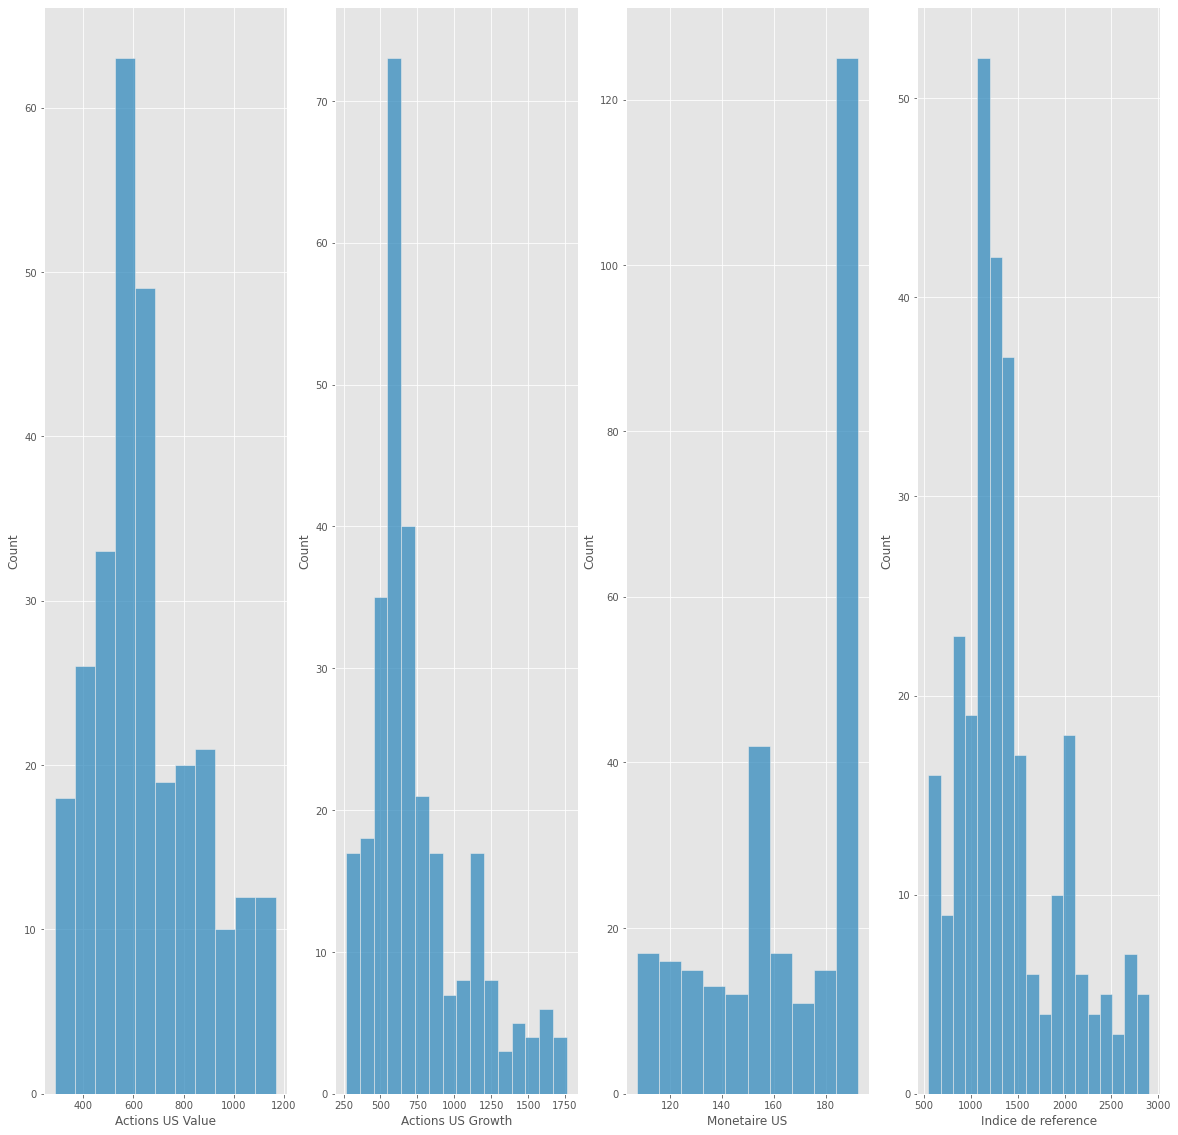

In [7]:
plt.figure(figsize=(20,20))
plt.style.use('ggplot')
i=1
for col in data.select_dtypes(['int64','float64']).columns:
    #sns.lineplot(data=data,x="date 2",y="Action US Growth")
    plt.subplot(1,4,i)
    sns.histplot(data, x=col)
    i+=1
plt.show()

Action US value, Action US growth et l'indice de référence ont des distribution similaire elles suivent donc la même loi de probabilités.

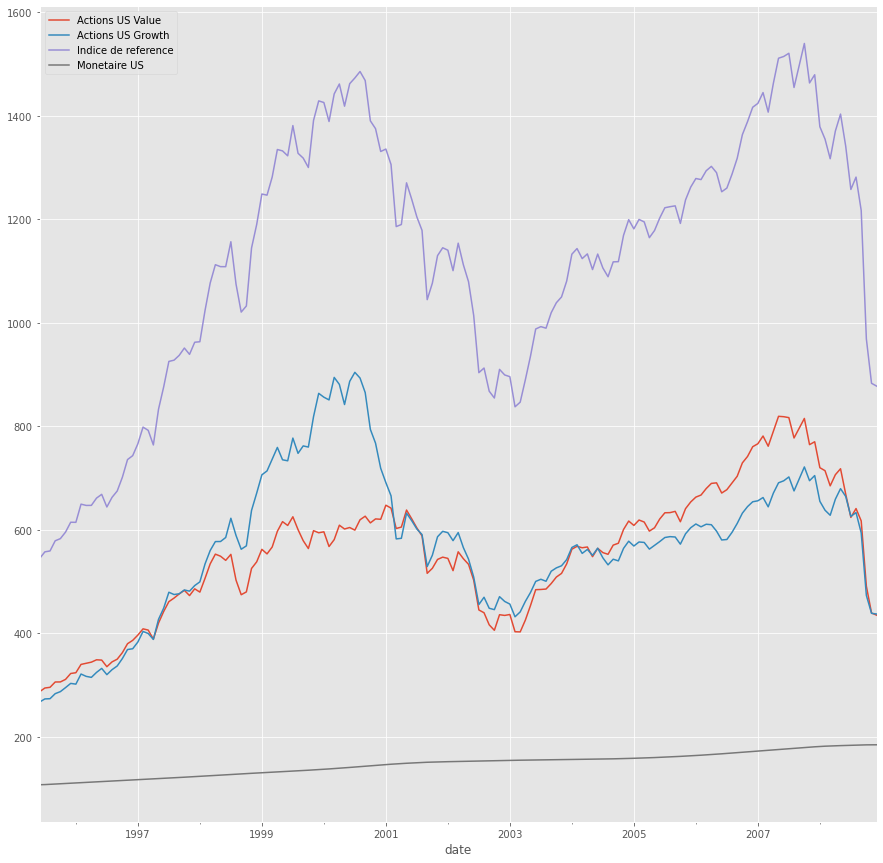

In [8]:
plt.figure(figsize=(15,15))
data['Actions US Value'][:"2008"].plot(kind='line')
data['Actions US Growth'][:"2008"].plot(kind='line')
data['Indice de reference'][:"2008"].plot(kind='line')
data['Monetaire US'][:"2008"].plot(kind='line')
plt.legend()
plt.show()


Les variables Actions US Value, Indice de référence et Action US Growth ont une évolution similaire au cours du temps. En effet, elles ont de manière générale une tendance croissante au cours du temps, deplus elles ont des pics et creux en même temps. On peut donc penser qu'elles sont fortement corrélées entre elle.
Contrairement aux autres variables monétaire US n'a pas de pic/ creux au fil du temps. On note également une légère tendance croissante, cependant il est assez difficile à dire si elle est corréler aux autres variables.

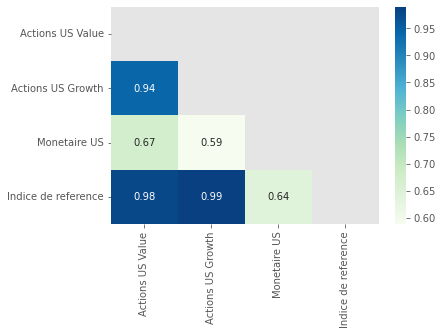

In [9]:
mask = np.triu(np.ones_like(data.corr()))
plt.figure()
sns.heatmap(data.corr(),annot=True,mask=mask,cmap='GnBu')
plt.show()

La heatmap de matrice de corrélation va dans le sens de la 1er constatation.
Actions US Value, Indice de référence et Action US Growth sont fortement corréler entre elles.
Monétaire US a également une correlation non négligeable avec les autres variables sans pour autant etre trop fortement prononcé.

In [10]:
path="days"
#new_data=pd.read_csv("C:/Users/ranus/OneDrive/Bureau/projet gestion d'actif/data actif/AAA10Y.csv").set_index('DATE').rename_axis('date', axis=0)
i=0 # on créer un itérateur pour faciliter l'initialisation des data qui servira a accueillir les différents merge
for dirname,_,filenames in os.walk(path):
    #if dirname=='ModerateDemented':
    for file in filenames:
        p=path+'/'+str(file) # chemin d'accès de la série temporelle
        if i==0:
            data_days=pd.read_csv(p)
            data_days["date"]=pd.to_datetime(data_days["date"],format='%Y-%m-%d')
            data_days=data_days.set_index('date')
            data_days=data_days.resample('M').mean()
            i+=1
        else:
            new_data=pd.read_csv(p)
            new_data["date"]=pd.to_datetime(new_data["date"],format='%Y-%m-%d')
            new_data=new_data.set_index('date')
              #Certaine colonne sont considérer à tord comme object et certaine valeur ne peuvent être convertie  en float car ils sont égle '.' au lieu de '0.0'                       new_data[str(file)]=new_data[file.split('.')[0]].astype(np.float64) #maintenant on peut convertir les colonnes 

            new_data[str(file)]=new_data[file.split('.')[0]].replace('.','0.0',inplace=True) # on transforme les '.' en 0
            new_data[str(file)]=new_data[file.split('.')[0]].astype(np.float64) #maintenant on peut convertir les colonnes 
            new_data=new_data.resample('M').mean()
            data_days=pd.merge(data_days, new_data, left_index=True, right_index=True,how='outer')
#plt.figure()
#sns.heatmap(data_days.isna())
#plt.show()

# convert les columns objet en flaot
#for col in data_days.select_dtypes("object").columns:
 #   data_days[col] = pd.to_numeric(data_days[col],errors='coerce', downcast="float")
new_data
data_days
#plt.figure()
#for col in data_days.columns:
 #   data_days[col].plot()
#plt.show()

C:\Users\ranus\AppData\Local\Temp\ipykernel_16844\834531625.py:12: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  data_days=data_days.resample('M').mean()


,BAMLC0A2CAAEY.csv,BAMLC0A3CAEY.csv,BAMLC0A4CBBB.csv,BAMLH0A0HYM2.csv,DAAA.csv,DBAA.csv,DED1.csv,DEXUSUK.csv,DFF,DFF.csv,DGS1.csv,NASDAQCOM.csv,T10Y2Y.csv,VIXCLS.csv,WILLLRGCAPGR.csv
date,,,,,,,,,,,,,,,
1962-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.279545,NaN,NaN,NaN,NaN
1962-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.955500,NaN,NaN,NaN,NaN
1962-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.058182,NaN,NaN,NaN,NaN
1962-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.845238,NaN,NaN,NaN,NaN
1962-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.894348,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,4.796957,5.240435,1.772174,4.691304,4.596087,5.714348,NaN,1.213778,4.649032,4.649032,4.679130,11637.092174,-0.639565,21.644348,136643.426087
2023-04-30,4.335238,4.750952,1.650952,4.348095,4.242000,5.256500,NaN,1.244575,4.830000,4.830000,4.681000,11469.791000,-0.556000,16.927000,135685.529000
2023-05-31,4.697826,5.157391,1.796087,4.688261,4.464348,5.515652,NaN,1.194096,5.055806,5.055806,4.699130,11905.376957,-0.533913,17.636087,141056.122609


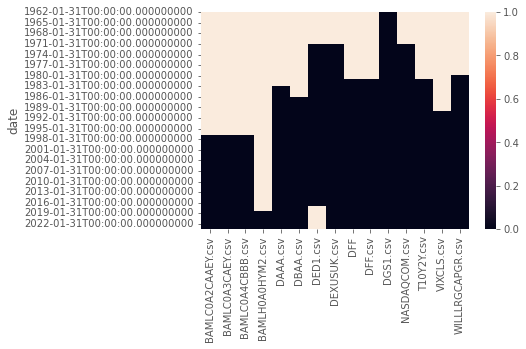

In [11]:
plt.figure()
sns.heatmap(data_days.isna())

plt.show()


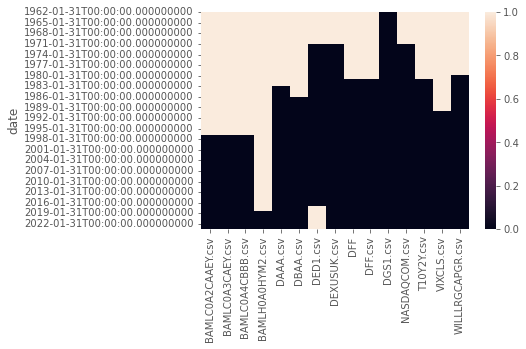

,BAMLC0A2CAAEY.csv,BAMLC0A3CAEY.csv,BAMLC0A4CBBB.csv,DAAA.csv,DBAA.csv,DEXUSUK.csv,DFF,DFF.csv,DGS1.csv,NASDAQCOM.csv,T10Y2Y.csv,VIXCLS.csv,WILLLRGCAPGR.csv
date,,,,,,,,,,,,,
1996-12-31,6.820000,6.970000,0.830000,6.876364,7.534091,1.588300,5.294516,5.294516,5.223182,1233.416818,0.496818,18.385455,678.692727
1997-01-31,6.657826,6.787391,0.796522,7.095652,7.743478,1.514296,5.254516,5.254516,5.124348,1286.923478,0.521304,17.780000,699.398696
1997-02-28,6.479000,6.599500,0.769000,6.940000,7.544500,1.544350,5.185714,5.185714,5.249000,1281.711500,0.495000,19.132500,799.258000
1997-03-31,6.773810,6.891905,0.727619,7.199524,7.792857,1.609557,5.386129,5.386129,5.519524,1221.767143,0.450000,19.209524,722.923810
1997-04-30,7.312727,7.445455,0.779091,7.725909,8.336818,1.629323,5.507333,5.507333,5.988182,1225.003636,0.437273,19.662273,740.797273
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,4.789500,5.115000,1.550500,4.336000,5.314500,1.147980,4.570000,4.570000,4.679000,11195.820500,-0.747500,20.120500,130949.252000
2023-03-31,4.796957,5.240435,1.772174,4.596087,5.714348,1.213778,4.649032,4.649032,4.679130,11637.092174,-0.639565,21.644348,136643.426087
2023-04-30,4.335238,4.750952,1.650952,4.242000,5.256500,1.244575,4.830000,4.830000,4.681000,11469.791000,-0.556000,16.927000,135685.529000


In [12]:
#plt.figure()
#sns.heatmap(data_days.drop(["DED1","BAMLH0A0HYM2"],axis=1).resample('M').mean().isna())
#plt.show()
plt.figure()
sns.heatmap(data_days.isna())
plt.show()

d=data_days.drop(["DED1.csv","BAMLH0A0HYM2.csv"],axis=1)
d=d.dropna(axis=0)
d

#on retire DED1et BAMLHOAHYM2.csv qui n'ont pas les 25 ans d'historique

month/CPALTT01USM657N.csv
month/CSUSHPINSA.csv
month/CSUSHPISA.csv
month/EMVMACROBUS.csv
month/EMVMACROFININD.csv
month/EMVOVERALLEMV.csv
month/EPUMONETARY.csv
month/EXJPUS.csv
month/FEDFUNDS.csv
month/FRACPIENGMINMEI.csv
month/H8B1027NCBCMG.csv
month/IPMAN.csv
month/IQ12260.csv
month/IRSTCI01USM156N.csv
month/LOCOCIORNZQ665S.csv
month/OECDLOLITOAASTSAM.csv
month/PAYEMS.csv
month/PNRGINDEXM.csv
month/UMCSENT.csv
month/UNEMPLOY.csv


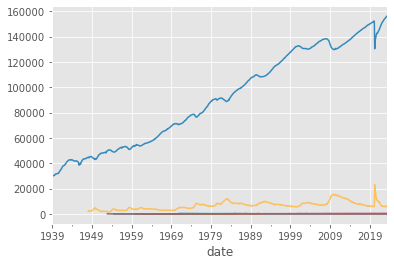

,BAAFFM,CPALTT01USM657N,CSUSHPINSA,CSUSHPISA,EMVMACROBUS,EMVMACROFININD,EMVOVERALLEMV,EPUMONETARY,EXJPUS,FEDFUNDS,FRACPIENGMINMEI,H8B1027NCBCMG,IPMAN,IQ12260,IRSTCI01USM156N,PAYEMS,PNRGINDEXM,UMCSENT,UNEMPLOY
date,,,,,,,,,,,,,,,,,,,
1939-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29923.0,NaN,NaN,NaN
1939-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30100.0,NaN,NaN,NaN
1939-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30280.0,NaN,NaN,NaN
1939-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30094.0,NaN,NaN,NaN
1939-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30299.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,1.02,0.558211,293.390,297.018,0.00000,0.71043,18.82643,131.187173,133.0463,4.57,156.74620,0.9,100.1772,671.3,4.57,155255.0,201.718393,67.0,5936.0
2023-03-31,1.06,0.331073,297.077,298.149,0.16770,1.84471,31.19244,212.835216,133.6643,4.65,157.29699,-2.3,99.5000,642.4,4.65,155472.0,186.023155,62.0,5839.0
2023-04-30,0.70,0.505904,NaN,299.715,0.15942,0.95670,21.04739,161.574091,133.4745,4.83,156.13376,-0.9,100.4791,702.5,4.83,155766.0,192.368523,63.5,5657.0


In [13]:
path="month"
#new_data=pd.read_csv("C:/Users/ranus/OneDrive/Bureau/projet gestion d'actif/data actif/AAA10Y.csv").set_index('DATE').rename_axis('date', axis=0)
i=0 # on créer un itérateur pour faciliter l'initialisation des data qui servira a accueillir les différents merge
for dirname,_,filenames in os.walk(path):
    for file in filenames:
        p=path+'/'+str(file) # chemin d'accès de la série temporelle
        if i==0:#permet d'initaliser la dataframe
            data_month=pd.read_csv(p)
            data_month["date"]=pd.to_datetime(data_month["date"],format='%Y-%m-%d')
            data_month=data_month.set_index('date')
            data_month=data_month.resample('M').mean()

            i+=1
        else:
            new_data=pd.read_csv(p)
            new_data["date"]=pd.to_datetime(new_data["date"],format='%Y-%m-%d')
            new_data=new_data.set_index('date')
            #Certaine colonne sont considérer à tord comme object et certaine valeur ne peuvent être convertie  en float car ils sont égle '.' au lieu de '0.0'
            new_data[file.split('.')[0]].replace('.','0.0',inplace=True) # on transforme les '.' en 0
            new_data[file.split('.')[0]]=new_data[file.split('.')[0]].astype(np.float64) #maintenant on peut convertir les colonnes 
            new_data=new_data.resample('M').mean()
            data_month=pd.merge(data_month, new_data, left_index=True, right_index=True,how='outer')
            print(p)
#plt.figure()
#sns.heatmap(data_days.isna())
#plt.show()





#-------------------------------- certaine variables semblent avoir mal fusionnées avec la data frame, on va les refusionner
data_month=data_month.drop(["LOCOCIORNZQ665S","OECDLOLITOAASTSAM"],axis=1)



#OECDLOLITOAASTSAM=pd.read_csv("C:/Users/ranus/OneDrive/Bureau/projet gestion d'actif/data actif/month/OECDLOLITOAASTSAM.csv")
#OECDLOLITOAASTSAM["date"]=pd.to_datetime(OECDLOLITOAASTSAM["date"],format='%Y-%m-%d')
#OECDLOLITOAASTSAM=OECDLOLITOAASTSAM.set_index('date')
#OECDLOLITOAASTSAM=OECDLOLITOAASTSAM.resample('M').mean()

#data_month=pd.merge(data_month, OECDLOLITOAASTSAM, left_index=True, right_index=True,how='outer')


plt.figure()
for col in data_month.columns:
 
    data_month[col].plot()
plt.show()
data_month

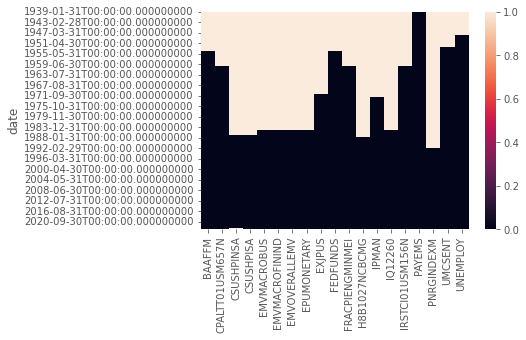

In [14]:
plt.figure()
sns.heatmap(data_month.isna())
plt.show()

In [15]:

#data_month=data_month.drop('LOCOCIORNZQ665S',axis=1)
data_month=data_month.dropna(axis=0)
data_month


,BAAFFM,CPALTT01USM657N,CSUSHPINSA,CSUSHPISA,EMVMACROBUS,EMVMACROFININD,EMVOVERALLEMV,EPUMONETARY,EXJPUS,FEDFUNDS,FRACPIENGMINMEI,H8B1027NCBCMG,IPMAN,IQ12260,IRSTCI01USM156N,PAYEMS,PNRGINDEXM,UMCSENT,UNEMPLOY
date,,,,,,,,,,,,,,,,,,,
1992-01-31,5.10,0.145033,75.699,76.086,0.22069,0.99311,20.80009,160.128045,125.4614,4.03,54.273314,5.7,58.0760,0.0,4.03,108367.0,44.452235,67.5,9283.0
1992-02-29,5.17,0.362056,75.654,76.155,0.22603,0.33904,16.66967,160.020410,127.6989,4.06,54.318274,1.4,58.6426,0.0,4.06,108313.0,44.012857,68.8,9454.0
1992-03-31,5.27,0.505051,75.813,76.277,0.56230,0.46006,15.99999,95.025307,132.8627,3.98,54.313326,1.4,59.2631,124.3,3.98,108360.0,43.828585,76.0,9460.0
1992-04-30,5.48,0.143575,76.079,76.345,0.53363,0.58699,18.30347,71.477952,133.5395,3.73,54.213200,7.1,59.6067,0.0,3.73,108515.0,46.155698,77.2,9415.0
1992-05-31,5.31,0.143369,76.397,76.398,0.15958,0.63832,14.57487,48.040744,130.7710,3.82,54.287954,7.1,59.9612,0.0,3.82,108648.0,48.205262,79.2,9744.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,2.32,-0.101003,296.809,298.039,0.54907,0.54907,17.70746,195.661123,142.4450,3.78,154.326810,0.9,100.4743,577.9,3.78,154296.0,256.859739,56.8,6000.0
2022-12-31,1.50,-0.307009,294.266,296.952,0.00000,0.00000,21.67966,163.294743,134.9148,4.10,148.876690,2.4,98.3130,625.2,4.10,154535.0,258.501791,59.7,5722.0
2023-01-31,1.17,0.799536,292.444,296.455,1.05738,1.05738,20.09025,304.290451,130.4475,4.33,154.327740,0.0,99.8592,647.1,4.33,155007.0,223.272585,64.9,5694.0


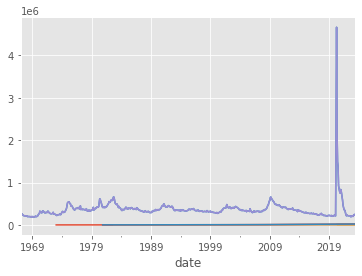

In [16]:
path="weekly"
#new_data=pd.read_csv("C:/Users/ranus/OneDrive/Bureau/projet gestion d'actif/data actif/AAA10Y.csv").set_index('DATE').rename_axis('date', axis=0)
i=0 # on créer un itérateur pour faciliter l'initialisation des data qui servira a accueillir les différents merge
for dirname,_,filenames in os.walk(path):
    #if dirname=='ModerateDemented':
    for file in filenames:
        p=path+'/'+str(file) # chemin d'accès de la série temporelle
       
    
    
        if i==0: #permet d'initaliser la dataframe
            data_week=pd.read_csv(p)
            data_week["date"]=pd.to_datetime(data_week["date"],format='%Y-%m-%d')
            data_week=data_week.set_index('date')
            #new_data[col[0]]=pd.to_numeric(new_data[col[0]])
            data_week=data_week.resample('M').mean()
            i+=1
        else:
            new_data=pd.read_csv(p)
            new_data["date"]=pd.to_datetime(new_data["date"],format='%Y-%m-%d')
            new_data=new_data.set_index('date')
              #Certaine colonne sont considérer à tord comme object et certaine valeur ne peuvent être convertie  en float car ils sont égle '.' au lieu de '0.0'
            new_data[file.split('.')[0]].replace('.','0.0',inplace=True) # on transforme les '.' en 0
            new_data[str(file)]=new_data[file.split('.')[0]].astype(np.float64) #maintenant on peut convertir les colonnes 
            new_data=new_data.resample('M').mean()
            data_week=pd.merge(data_week, new_data, left_index=True, right_index=True,how='outer')
#plt.figure()
#sns.heatmap(data_days.isna())
#plt.show()
plt.figure()
for col in data_week.columns:
    data_week[col].plot()
plt.show()



#Unable to parse string "." -----------> faire un resample('M').mean()

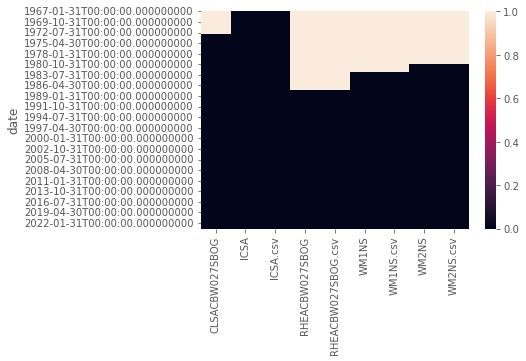

In [17]:
s=data_week.resample("m").mean()
plt.figure()
sns.heatmap(s.isna())
plt.show()

In [18]:
s=s.dropna(axis=0)
s

,CLSACBW027SBOG,ICSA,ICSA.csv,RHEACBW027SBOG,RHEACBW027SBOG.csv,WM1NS,WM1NS.csv,WM2NS,WM2NS.csv
date,,,,,,,,,
1987-06-30,316.378900,322250.0,322250.0,23.764450,23.764450,742.520,742.520,2771.020,2771.020
1987-07-31,316.075420,319250.0,319250.0,24.844720,24.844720,748.200,748.200,2787.150,2787.150
1987-08-31,319.148425,325600.0,325600.0,26.041825,26.041825,743.040,743.040,2785.820,2785.820
1987-09-30,321.637680,309750.0,309750.0,27.339480,27.339480,744.775,744.775,2793.550,2793.550
1987-10-31,324.264575,300000.0,300000.0,28.418550,28.418550,753.500,753.500,2810.675,2810.675
...,...,...,...,...,...,...,...,...,...
2023-02-28,1853.750850,218500.0,218500.0,255.399675,255.399675,19337.225,19337.225,21115.100,21115.100
2023-03-31,1865.576400,242000.0,242000.0,254.887160,254.887160,19135.450,19135.450,21024.650,21024.650
2023-04-30,1876.123125,237000.0,237000.0,254.446875,254.446875,18854.150,18854.150,20883.675,20883.675


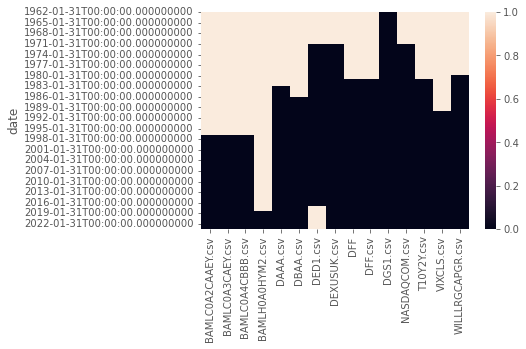

In [19]:
plt.figure()
sns.heatmap(data_days.isna())
plt.show()

In [20]:
data_final=pd.merge(data_month, s, left_index=True, right_index=True,how='inner')
data_final=pd.merge(data_final, d, left_index=True, right_index=True,how='inner')
data_final=pd.merge(data_final, data_composite, left_index=True, right_index=True,how='inner')
data_final=pd.merge(data_final, data, left_index=True, right_index=True,how='inner')
data_final

#plt.figure()
#sns.heatmap(data_final.isna())
#plt.show()

,BAAFFM,CPALTT01USM657N,CSUSHPINSA,CSUSHPISA,EMVMACROBUS,EMVMACROFININD,EMVOVERALLEMV,EPUMONETARY,EXJPUS,FEDFUNDS,FRACPIENGMINMEI,H8B1027NCBCMG,IPMAN,IQ12260,IRSTCI01USM156N,PAYEMS,PNRGINDEXM,UMCSENT,UNEMPLOY,CLSACBW027SBOG,ICSA,ICSA.csv,RHEACBW027SBOG,RHEACBW027SBOG.csv,WM1NS,WM1NS.csv,WM2NS,WM2NS.csv,BAMLC0A2CAAEY.csv,BAMLC0A3CAEY.csv,BAMLC0A4CBBB.csv,DAAA.csv,DBAA.csv,DEXUSUK.csv,DFF,DFF.csv,DGS1.csv,NASDAQCOM.csv,T10Y2Y.csv,VIXCLS.csv,WILLLRGCAPGR.csv,VIX,RUT,HSI,AAIIQ,FCHI,Actions US Value,Actions US Growth,Monetaire US,Indice de reference
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-12-31,2.60,0.000000,83.490,83.721,0.65315,1.00941,20.90072,60.654919,113.9810,5.29,61.171562,20.7,75.9361,134.6,5.29,121145.0,64.294940,96.9,7253.0,508.254050,353500.0,353500.0,85.737800,85.737800,1104.160,1104.160,3834.760,3834.760,6.820000,6.970000,0.830000,6.876364,7.534091,1.588300,5.294516,5.294516,5.223182,1233.416818,0.496818,18.385455,678.692727,15.999762,7.213657e+07,1.099593e+04,1149.548238,1.889079e+03,386.365714,370.142381,116.474452,743.252857
1997-01-31,2.84,0.315259,83.530,83.955,0.27409,0.54817,21.04977,53.131184,117.9124,5.25,61.615703,8.4,76.0189,131.3,5.25,121363.0,61.484579,97.4,7158.0,511.967060,339000.0,339000.0,86.309660,86.309660,1092.200,1092.200,3845.225,3845.225,6.657826,6.787391,0.796522,7.095652,7.743478,1.514296,5.254516,5.254516,5.124348,1286.923478,0.521304,17.780000,699.398696,16.273257,8.813599e+07,1.121956e+04,708.165591,1.993756e+03,396.566818,383.193182,117.031032,766.216818
1997-02-28,2.75,0.314268,83.596,84.180,0.27438,0.32926,19.48103,19.423843,122.9621,5.19,61.545489,11.9,77.0590,126.3,5.19,121675.0,53.480831,99.7,7102.0,509.782700,320750.0,320750.0,87.186625,87.186625,1067.950,1067.950,3831.625,3831.625,6.479000,6.599500,0.769000,6.940000,7.544500,1.544350,5.185714,5.185714,5.249000,1281.711500,0.495000,19.132500,799.258000,16.780175,8.524995e+07,1.116199e+04,387.575870,2.155136e+03,408.613158,403.533684,117.528195,798.387895
1997-03-31,2.79,0.250627,83.911,84.452,0.31591,0.68447,22.95618,60.959101,122.7738,5.39,61.123190,14.1,77.8510,123.3,5.39,121989.0,50.539143,100.0,7000.0,504.791375,319400.0,319400.0,88.639400,88.639400,1068.500,1068.500,3868.180,3868.180,6.773810,6.891905,0.727619,7.199524,7.792857,1.609557,5.386129,5.386129,5.519524,1221.767143,0.450000,19.209524,722.923810,16.760667,8.358871e+07,1.081898e+04,731.424200,2.195142e+03,406.246500,399.621500,118.011695,792.155500
1997-04-30,2.83,0.125000,84.320,84.622,0.66592,1.05437,23.86214,65.533380,125.6377,5.51,60.665035,9.3,77.7438,125.1,5.51,122284.0,47.813729,101.4,6873.0,505.617120,327000.0,327000.0,89.956440,89.956440,1074.975,1074.975,3910.350,3910.350,7.312727,7.445455,0.779091,7.725909,8.336818,1.629323,5.507333,5.507333,5.988182,1225.003636,0.437273,19.662273,740.797273,16.446894,7.925513e+07,1.038118e+04,347.237983,2.141299e+03,388.728182,388.183636,118.564177,763.928182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31,2.86,0.055554,205.340,203.735,0.33800,0.45066,14.98447,41.676663,110.9965,1.91,113.987540,-8.9,102.0176,426.3,1.91,149272.0,163.167847,96.2,6156.0,1475.319360,208500.0,208500.0,356.958320,356.958320,3664.825,3664.825,14160.950,14160.950,3.443043,3.742174,1.496087,3.884783,4.766087,1.287839,1.914839,1.914839,2.445652,7892.232391,0.253478,12.546957,86817.633043,10.489855,5.037918e+08,2.718205e+08,11.127301,1.114158e+07,1135.086817,1729.022242,190.960765,2857.820435
2018-09-30,2.93,0.116203,205.386,204.398,0.46224,0.30816,18.33542,20.149982,112.0974,1.95,115.037580,-7.6,102.0249,419.2,1.95,149361.0,172.605784,100.1,6073.0,1480.993425,205200.0,205200.0,354.553800,354.553800,3678.425,3678.425,14198.800,14198.800,3.538571,3.836190,1.473333,3.778000,4.639500,1.241300,1.954667,1.954667,2.430000,7584.142000,0.224500,12.265000,84058.477000,10.824298,5

In [21]:
data_month


,BAAFFM,CPALTT01USM657N,CSUSHPINSA,CSUSHPISA,EMVMACROBUS,EMVMACROFININD,EMVOVERALLEMV,EPUMONETARY,EXJPUS,FEDFUNDS,FRACPIENGMINMEI,H8B1027NCBCMG,IPMAN,IQ12260,IRSTCI01USM156N,PAYEMS,PNRGINDEXM,UMCSENT,UNEMPLOY
date,,,,,,,,,,,,,,,,,,,
1992-01-31,5.10,0.145033,75.699,76.086,0.22069,0.99311,20.80009,160.128045,125.4614,4.03,54.273314,5.7,58.0760,0.0,4.03,108367.0,44.452235,67.5,9283.0
1992-02-29,5.17,0.362056,75.654,76.155,0.22603,0.33904,16.66967,160.020410,127.6989,4.06,54.318274,1.4,58.6426,0.0,4.06,108313.0,44.012857,68.8,9454.0
1992-03-31,5.27,0.505051,75.813,76.277,0.56230,0.46006,15.99999,95.025307,132.8627,3.98,54.313326,1.4,59.2631,124.3,3.98,108360.0,43.828585,76.0,9460.0
1992-04-30,5.48,0.143575,76.079,76.345,0.53363,0.58699,18.30347,71.477952,133.5395,3.73,54.213200,7.1,59.6067,0.0,3.73,108515.0,46.155698,77.2,9415.0
1992-05-31,5.31,0.143369,76.397,76.398,0.15958,0.63832,14.57487,48.040744,130.7710,3.82,54.287954,7.1,59.9612,0.0,3.82,108648.0,48.205262,79.2,9744.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,2.32,-0.101003,296.809,298.039,0.54907,0.54907,17.70746,195.661123,142.4450,3.78,154.326810,0.9,100.4743,577.9,3.78,154296.0,256.859739,56.8,6000.0
2022-12-31,1.50,-0.307009,294.266,296.952,0.00000,0.00000,21.67966,163.294743,134.9148,4.10,148.876690,2.4,98.3130,625.2,4.10,154535.0,258.501791,59.7,5722.0
2023-01-31,1.17,0.799536,292.444,296.455,1.05738,1.05738,20.09025,304.290451,130.4475,4.33,154.327740,0.0,99.8592,647.1,4.33,155007.0,223.272585,64.9,5694.0


On convertie les données en rendement mensuelle à l'aide de la formule $(S_{T}-S_{t})/S_{t}$


In [22]:
def rendement(data):
    s0=data.shift(periods=1)
    s0[0]=s0[1]
    S_t= np.array(data)
    return (S_t-s0)/s0

i=0
for col in data_final.columns:
    if i==0:
        data_rendement=pd.DataFrame({col+"_rendement":rendement(data_final[col])},index=data_final.index)
        i+=1
    else:
        data_rendement=pd.merge(data_rendement,pd.DataFrame({col+"_rendement":rendement(data_final[col])},index=data_final.index),right_index=True,left_index=True,how='inner')
data_rendement[:"2008"].corr()

,BAAFFM_rendement,CPALTT01USM657N_rendement,CSUSHPINSA_rendement,CSUSHPISA_rendement,EMVMACROBUS_rendement,EMVMACROFININD_rendement,EMVOVERALLEMV_rendement,EPUMONETARY_rendement,EXJPUS_rendement,FEDFUNDS_rendement,FRACPIENGMINMEI_rendement,H8B1027NCBCMG_rendement,IPMAN_rendement,IQ12260_rendement,IRSTCI01USM156N_rendement,PAYEMS_rendement,PNRGINDEXM_rendement,UMCSENT_rendement,UNEMPLOY_rendement,CLSACBW027SBOG_rendement,ICSA_rendement,ICSA.csv_rendement,RHEACBW027SBOG_rendement,RHEACBW027SBOG.csv_rendement,WM1NS_rendement,WM1NS.csv_rendement,WM2NS_rendement,WM2NS.csv_rendement,BAMLC0A2CAAEY.csv_rendement,BAMLC0A3CAEY.csv_rendement,BAMLC0A4CBBB.csv_rendement,DAAA.csv_rendement,DBAA.csv_rendement,DEXUSUK.csv_rendement,DFF_rendement,DFF.csv_rendement,DGS1.csv_rendement,NASDAQCOM.csv_rendement,T10Y2Y.csv_rendement,VIXCLS.csv_rendement,WILLLRGCAPGR.csv_rendement,VIX_rendement,RUT_rendement,HSI_rendement,AAIIQ_rendement,FCHI_rendement,Actions US Value_rendement,Actions US Growth_rendement,Monetaire US_rendement,Indice de reference_rendement
BAAFFM_rendement,1.000000,0.084484,-0.343918,-0.350629,0.059082,0.084033,0.028275,0.074189,-0.134650,-0.493931,-0.031186,0.041308,-0.190423,0.085623,-0.493931,-0.313160,-0.146399,-0.269203,0.182225,0.141125,0.126603,0.126603,0.096642,0.096642,0.107393,0.107393,0.189044,0.189044,0.272831,0.335811,0.267863,0.292270,0.363875,-0.087593,-0.491056,-0.491056,-0.216197,-0.126612,-0.047539,0.221227,0.018635,0.221046,0.008158,0.029612,-0.005866,-0.046376,-0.226468,-0.253026,-0.014575,-0.251018
CPALTT01USM657N_rendement,0.084484,1.000000,0.016253,-0.079839,0.126122,-0.006435,-0.033582,0.159828,-0.059392,-0.096117,0.299112,0.044490,-0.072260,-0.097689,-0.096117,-0.037354,0.106403,-0.318084,-0.040209,0.058573,0.104608,0.104608,0.164268,0.164268,0.045006,0.045006,0.104739,0.104739,0.250494,0.242941,0.252114,0.234212,0.270308,0.010579,-0.092100,-0.092100,0.113376,-0.009383,0.086724,0.238843,-0.180544,0.200572,-0.075408,-0.088783,-0.019329,0.072930,-0.263715,-0.119039,-0.076409,-0.198268
CSUSHPINSA_rendement,-0.343918,0.016253,1.000000,0.883002,-0.009113,-0.001167,-0.062700,-0.055618,0.192638,0.611940,0.238774,0.027773,0.395650,-0.027424,0.611940,0.438872,0.300718,0.032128,-0.286317,-0.155332,-0.204017,-0.204017,0.172498,0.172498,-0.183968,-0.183968,-0.171612,-0.171612,0.057877,-0.024450,-0.314354,0.103096,-0.051517,0.139318,0.611233,0.611233,0.494302,0.104077,0.022685,-0.170880,-0.010526,-0.188130,-0.076533,0.051086,0.039780,0.042088,0.244889,0.157201,-0.078524,0.207802
CSUSHPISA_rendement,-0.350629,-0.079839,0.883002,1.000000,-0.060417,-0.023540,-0.070308,-0.031843,0.141516,0.549763,0.136800,0.043981,0.425607,0.015545,0.549763,0.454739,0.200053,0.080173,-0.313604,-0.124426,-0.226994,-0.226994,0.218963,0.218963,-0.134813,-0.134813,-0.100625,-0.100625,-0.033109,-0.106741,-0.312282,0.009520,-0.120282,0.106094,0.549025,0.549025,0.375352,0.082654,0.072389,-0.190165,0.018783,-0.189099,-0.038260,0.026077,0.007881,0.080163,0.239039,0.142923,-0.100731,0.197955
EMVMACROBUS_rendement,0.059082,0.126122,-0.009113,-0.060417,1.000000,0.139431,0.324709,0.420517,-0.147550,0.057778,0.025041,0.085756,0.009095,-0.061170,0.057778,0.037988,0.021669,-0.042833,-0.119808,0.078833,0.033949,0.033949,-0.029338,-0.029338,0.061934,0.061934,0.136279,0.136279,-0.040846,-0.023609,0.199202,0.067457,0.061312,0.129211,0.054246,0.054246,-0.022357,-0.154170,0.056179,0.327421,-0.042020,0.329742,0.116721,0.013638,-0.039917,-0.001963,-0.171112,-0.209093,0.062507,-0.200118
EMVMACROFININD_rendement,0.084033,-0.006435,-0.001167,-0.023540,0.139431,1.000000,0.389363,0.178225,0.101461,0.010281,0.025174,-0.027144,-0.128140,-0.040758,0.010281,-0.058193,0.007584,0.071850,0.019155,-0.052915,0.175883,0.175883,-0.008333,-0.008333,0.074192,0.074192,0.136919,0.136919,0.066698,0.102749,0.118171,0.152748,0.171756,0.081514,0.010108,0.010108,-0.021059,-0.101831,0.002658,0.275779,-0.019583,0.221157,0.136490,0.045208,-0.029880,-0.003583,-0.166425,-0.298181,0.070598,-0.2

In [23]:
#will ipman nasdaq dbaa icsa VIX





compo=['UNEMPLOY_rendement','PAYEMS_rendement','UMCSENT_rendement', "BAMLC0A4CBBB.csv_rendement", "VIX_rendement", "NASDAQCOM.csv_rendement", "EMVOVERALLEMV_rendement", "WM1NS_rendement",'Indice de reference_rendement','Actions US Growth_rendement','Monetaire US_rendement','Actions US Value_rendement']

#compo=["OECDLOLITOAASTSAM_x_rendement", "BAMLC0A4CBBB.csv_rendement", "VIX_rendement", "NASDAQCOM.csv_rendement", "EMVOVERALLEMV_rendement", "WM1NS_rendement",'Indice de reference_rendement','Actions US Growth_rendement','Monetaire US_rendement','Actions US Value_rendement']
#compo=["UMCSENT_rendement",'VIX_rendement',"NASDAQCOM.csv_rendement","CSUSHPINSA_rendement",'DBAA.csv_rendement','WILLLRGCAPGR.csv_rendement']



def _color_red_or_green(val):
    if val > 0.5:
        color = 'lightgreen' 
    elif val<-0.5:
        color='red'
    else:
        color='lightgrey'
    #return 'color: %s' % color
    return 'background-color: %s' % color
data_rendement[compo].corr().style.applymap(_color_red_or_green)
#variable_correler=correlation[(correlation>0.5) | (correlation<-0.5)]["Actions US Value"].dropna(axis=0).index
#variable_correler=correlation[(correlation>0.5)]["Actions US Value"].dropna(axis=0).index


,UNEMPLOY_rendement,PAYEMS_rendement,UMCSENT_rendement,BAMLC0A4CBBB.csv_rendement,VIX_rendement,NASDAQCOM.csv_rendement,EMVOVERALLEMV_rendement,WM1NS_rendement,Indice de reference_rendement,Actions US Growth_rendement,Monetaire US_rendement,Actions US Value_rendement
UNEMPLOY_rendement,1.000000,-0.406964,-0.092697,0.076793,-0.025004,0.003528,-0.098778,-0.006928,-0.139747,-0.117420,0.049106,-0.153905
PAYEMS_rendement,-0.406964,1.000000,0.016235,-0.015700,0.005504,0.094480,0.003491,-0.135949,0.228263,0.210744,0.186825,0.227257
UMCSENT_rendement,-0.092697,0.016235,1.000000,-0.251095,-0.248636,0.117175,-0.081637,-0.010874,0.351309,0.310168,-0.078558,0.368620
BAMLC0A4CBBB.csv_rendement,0.076793,-0.015700,-0.251095,1.000000,0.512477,-0.267503,0.245407,-0.089826,-0.584507,-0.531524,0.166868,-0.593379
VIX_rendement,-0.025004,0.005504,-0.248636,0.512477,1.000000,-0.423032,0.599621,0.049271,-0.706146,-0.679931,0.051785,-0.678155
NASDAQCOM.csv_rendement,0.003528,0.094480,0.117175,-0.267503,-0.423032,1.000000,-0.388137,-0.071448,0.609171,0.648375,-0.044753,0.519622
EMVOVERALLEMV_rendement,-0.098778,0.003491,-0.081637,0.245407,0.599621,-0.388137,1.000000,0.151022,-0.442015,-0.449824,0.033178,-0.398462
WM1NS_rendement,-0.006928,-0.135949,-0.010874,-0.089826,0.049271,-0.071448,0.151022,1.000000,-0.035774,-0.040985,-0.195560,-0.028057
Indice de reference_rendement,-0.139747,0.228263,0.351309,-0.584507,-0.706146,0.609171,-0.442015,-0.035774,1.000000,0.964860,-0.018213,0.961188
Actions US Growth_rendement,-0.117420,0.210744,0.310168,-0.531524,-0.679931,0.648375,-0.449824,-0.040985,0.964860,1.000000,-0.033329,0.855157


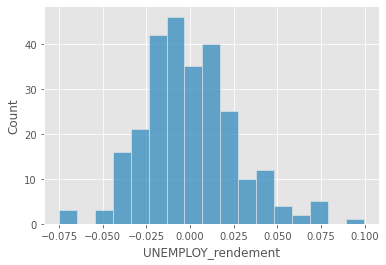

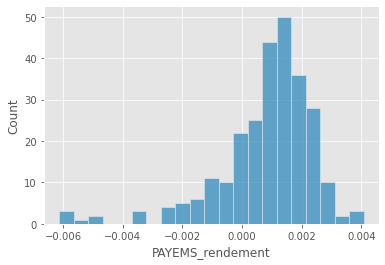

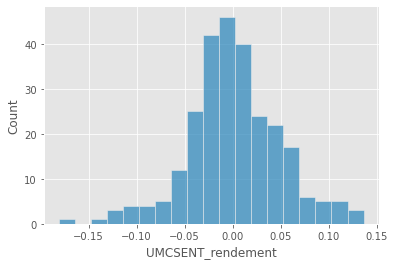

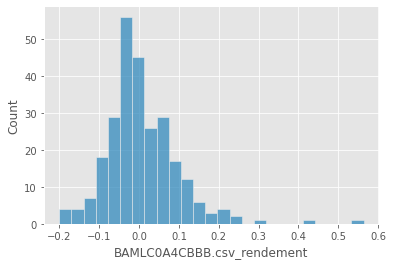

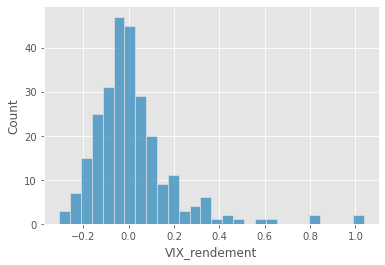

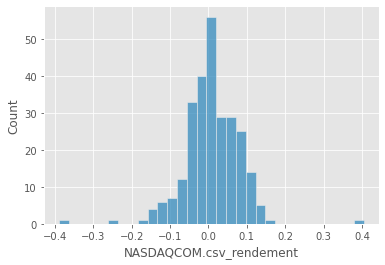

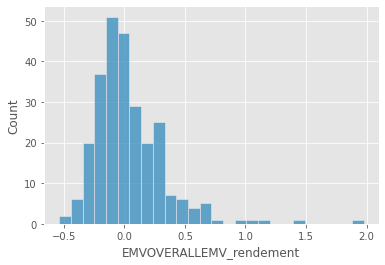

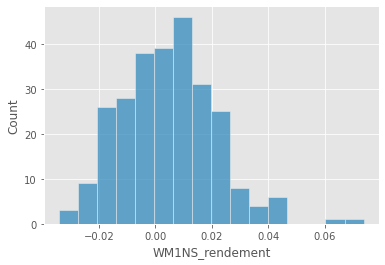

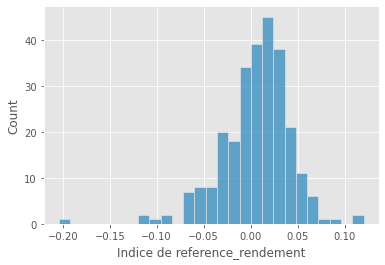

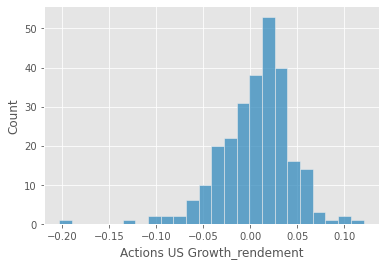

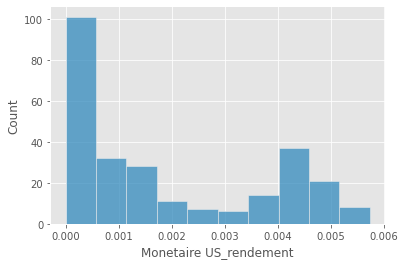

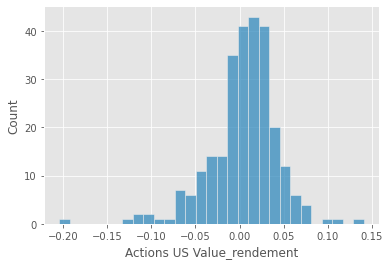

In [24]:
for col in compo:
    plt.figure()
    sns.histplot(data_rendement,x=col)
    plt.show()

## Z-score mobile
On a le choix entre faire du ranking et du Z-score. Comme la majorité des rendements on une distribution gaussien avec un skew, on va faire l'hypothèse qu'elles sont toute gaussienne et faire un Z-score mobile.


In [25]:
data_rendement[compo]

#fonction qui calcule le Z-score
def Z_score(data):
    mu=np.asarray(data.rolling(window=6).mean())
    sigma=np.asarray(data.rolling(window=6).std())
    x=np.asarray(data)
    return (x-mu)/sigma


i=0
for col in compo:
    if i==0:
        score=pd.DataFrame({col+"_Z-score":Z_score(data_rendement[col])},index=data_rendement.index)
        i+=1
    else:
        score=pd.merge(score,pd.DataFrame({col+"_Z-score":Z_score(data_rendement[col])},index=data_rendement.index),right_index=True,left_index=True,how='inner')
score
        

,UNEMPLOY_rendement_Z-score,PAYEMS_rendement_Z-score,UMCSENT_rendement_Z-score,BAMLC0A4CBBB.csv_rendement_Z-score,VIX_rendement_Z-score,NASDAQCOM.csv_rendement_Z-score,EMVOVERALLEMV_rendement_Z-score,WM1NS_rendement_Z-score,Indice de reference_rendement_Z-score,Actions US Growth_rendement_Z-score,Monetaire US_rendement_Z-score,Actions US Value_rendement_Z-score
date,,,,,,,,,,,,
1996-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31,0.147292,0.502156,-0.768412,-1.473165,0.454218,0.885581,1.428006,-0.724531,0.864130,0.446519,1.020113,1.363173
2018-09-30,-0.110935,-0.886248,1.841564,-0.780101,1.018233,-1.032486,1.220490,0.153619,0.218037,0.119169,0.947776,0.380693
2018-10-31,0.880348,-0.184832,-0.699396,-0.110118,1.901035,-0.353875,1.212103,0.865525,-2.023818,-1.994730,1.154972,-1.941254


In [26]:
#plt.figure()
score.corr().style.applymap(_color_red_or_green)



#for col in score.columns: 
 #   plt.figure()
  #  score[col].resample('Y').plot()
   # plt.ylabel(col)
    #plt.show()


,UNEMPLOY_rendement_Z-score,PAYEMS_rendement_Z-score,UMCSENT_rendement_Z-score,BAMLC0A4CBBB.csv_rendement_Z-score,VIX_rendement_Z-score,NASDAQCOM.csv_rendement_Z-score,EMVOVERALLEMV_rendement_Z-score,WM1NS_rendement_Z-score,Indice de reference_rendement_Z-score,Actions US Growth_rendement_Z-score,Monetaire US_rendement_Z-score,Actions US Value_rendement_Z-score
UNEMPLOY_rendement_Z-score,1.000000,-0.020124,-0.114662,0.052383,-0.006883,0.034699,-0.016499,-0.027098,-0.071543,-0.038107,0.047930,-0.090068
PAYEMS_rendement_Z-score,-0.020124,1.000000,0.005097,-0.065039,-0.068131,0.033876,0.057099,-0.078211,0.101480,0.095436,0.001299,0.104254
UMCSENT_rendement_Z-score,-0.114662,0.005097,1.000000,-0.142047,-0.160911,0.012143,-0.105120,-0.025372,0.225363,0.201244,-0.041406,0.242041
BAMLC0A4CBBB.csv_rendement_Z-score,0.052383,-0.065039,-0.142047,1.000000,0.443184,-0.239878,0.207846,-0.165463,-0.556700,-0.485925,0.012259,-0.575078
VIX_rendement_Z-score,-0.006883,-0.068131,-0.160911,0.443184,1.000000,-0.338180,0.504798,0.051500,-0.738029,-0.726271,0.010036,-0.681688
NASDAQCOM.csv_rendement_Z-score,0.034699,0.033876,0.012143,-0.239878,-0.338180,1.000000,-0.293732,0.086748,0.488944,0.496106,-0.061174,0.426921
EMVOVERALLEMV_rendement_Z-score,-0.016499,0.057099,-0.105120,0.207846,0.504798,-0.293732,1.000000,0.110375,-0.381492,-0.410925,0.084111,-0.324289
WM1NS_rendement_Z-score,-0.027098,-0.078211,-0.025372,-0.165463,0.051500,0.086748,0.110375,1.000000,0.062910,0.046604,-0.066593,0.063436
Indice de reference_rendement_Z-score,-0.071543,0.101480,0.225363,-0.556700,-0.738029,0.488944,-0.381492,0.062910,1.000000,0.953311,-0.007112,0.946640
Actions US Growth_rendement_Z-score,-0.038107,0.095436,0.201244,-0.485925,-0.726271,0.496106,-0.410925,0.046604,0.953311,1.000000,0.010857,0.816323


On va mettre en place un indicateur de risque.  
Certain Z-score ne sont pas anti-correler on va donc leur impliquer un coefficient -1

In [27]:
for col in score.corr()[score.corr()["Indice de reference_rendement_Z-score"]>0].drop(['Indice de reference_rendement_Z-score','Actions US Growth_rendement_Z-score','Actions US Value_rendement_Z-score'],axis=0).index:
    score[col]=score[col]*-1
    
score.corr().style.applymap(_color_red_or_green)



,UNEMPLOY_rendement_Z-score,PAYEMS_rendement_Z-score,UMCSENT_rendement_Z-score,BAMLC0A4CBBB.csv_rendement_Z-score,VIX_rendement_Z-score,NASDAQCOM.csv_rendement_Z-score,EMVOVERALLEMV_rendement_Z-score,WM1NS_rendement_Z-score,Indice de reference_rendement_Z-score,Actions US Growth_rendement_Z-score,Monetaire US_rendement_Z-score,Actions US Value_rendement_Z-score
UNEMPLOY_rendement_Z-score,1.000000,0.020124,0.114662,0.052383,-0.006883,-0.034699,-0.016499,0.027098,-0.071543,-0.038107,0.047930,-0.090068
PAYEMS_rendement_Z-score,0.020124,1.000000,0.005097,0.065039,0.068131,0.033876,-0.057099,-0.078211,-0.101480,-0.095436,-0.001299,-0.104254
UMCSENT_rendement_Z-score,0.114662,0.005097,1.000000,0.142047,0.160911,0.012143,0.105120,-0.025372,-0.225363,-0.201244,0.041406,-0.242041
BAMLC0A4CBBB.csv_rendement_Z-score,0.052383,0.065039,0.142047,1.000000,0.443184,0.239878,0.207846,0.165463,-0.556700,-0.485925,0.012259,-0.575078
VIX_rendement_Z-score,-0.006883,0.068131,0.160911,0.443184,1.000000,0.338180,0.504798,-0.051500,-0.738029,-0.726271,0.010036,-0.681688
NASDAQCOM.csv_rendement_Z-score,-0.034699,0.033876,0.012143,0.239878,0.338180,1.000000,0.293732,0.086748,-0.488944,-0.496106,0.061174,-0.426921
EMVOVERALLEMV_rendement_Z-score,-0.016499,-0.057099,0.105120,0.207846,0.504798,0.293732,1.000000,-0.110375,-0.381492,-0.410925,0.084111,-0.324289
WM1NS_rendement_Z-score,0.027098,-0.078211,-0.025372,0.165463,-0.051500,0.086748,-0.110375,1.000000,-0.062910,-0.046604,0.066593,-0.063436
Indice de reference_rendement_Z-score,-0.071543,-0.101480,-0.225363,-0.556700,-0.738029,-0.488944,-0.381492,-0.062910,1.000000,0.953311,-0.007112,0.946640
Actions US Growth_rendement_Z-score,-0.038107,-0.095436,-0.201244,-0.485925,-0.726271,-0.496106,-0.410925,-0.046604,0.953311,1.000000,0.010857,0.816323


Verifions la robustesse de nos Z-score

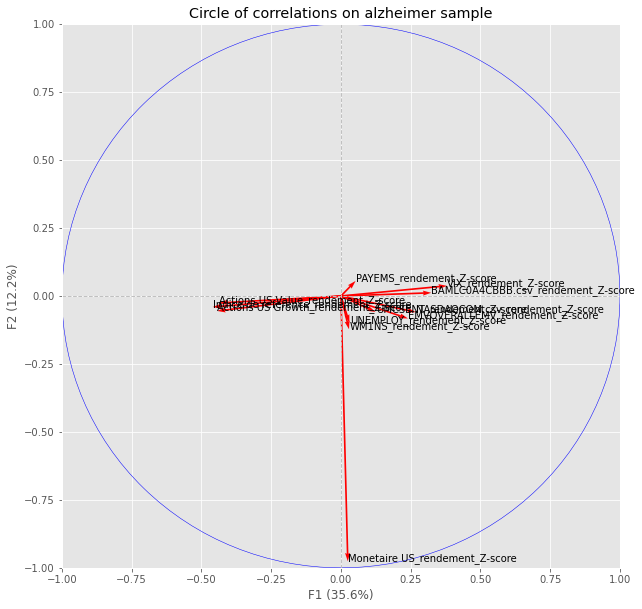

In [28]:
pca =PCA(n_components=2)
components = pca.fit(score.dropna(axis=0))

res=pca.transform(score.dropna(axis=0))

pcs = components.components_

fig = plt.subplots(figsize=(10,10))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
           pcs[0,:], pcs[1,:], angles='uv', scale_units='xy', scale=1, color='r', width= 0.003)

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.text(x, y, score.dropna(axis=0).columns[i])
   
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)

plt.title('Circle of correlations on alzheimer sample')
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))

plt.show()

## Agrégation

On va agréger nos mesures. En réalisant une moyenne pondérés. Comme la plus part des articles on considérer qu'il était peu efficace de mettre des poids différents au composite, nous alors faire une moyenne classique (le même poids pour les mesure) 

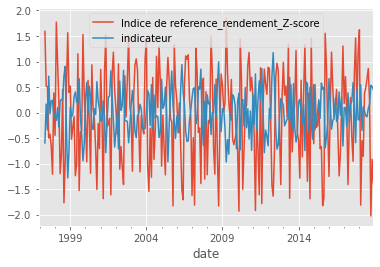

In [29]:
#-------------- sans pondération---------------------------
indicateur=score.drop(['Indice de reference_rendement_Z-score','Actions US Growth_rendement_Z-score','Monetaire US_rendement_Z-score','Actions US Value_rendement_Z-score'],axis=1).mean(axis=1)

#indicateur=pd.DataFrame({'indicateur':np.average(score.drop(["Indice de reference_rendement_Z-score","Actions US Growth_rendement_Z-score","Monetaire US_rendement_Z-score","Actions US Value_rendement_Z-score"],
           #axis=1).to_numpy(),axis=1,weights=[0.05,0.05,0.1,0.1,0.2,0.5])},index=score.index)
           
indicateur=pd.DataFrame({"indicateur":indicateur})

plt.figure()
for col in ['Indice de reference_rendement_Z-score','indicateur']:
    pd.merge(indicateur,score['Indice de reference_rendement_Z-score'],right_index=True, left_index=True,how="inner")[col].plot()
    plt.legend()
plt.show()
#plt.figure()
#score.mean(axis=1).plot()
#plt.show()

## Stratégie

### 1) In sample

Mettons désormais en place notre stratégie.  
On va mettre en place une stratégie en se basant sur les données 1998 à 2008.   
On remarque que lorsque notre indice est croissant, Action US Growth et Action US Value sont décroissant. A contrario Monétaire US est corréler à notre indice. 
   - Il est donc préférable de mettre plus de poids sur monétaire US quand quand l'indice est élevé.
   - Il est donc préférable de mettre plus de poids sur Action US Growth et Action US Value quand l'indice est bas.  

De plus, Action US Growth semble avoir de meilleurs pic/creus que Action US Value. Il est donc préférable d'investir  Action US Growth.

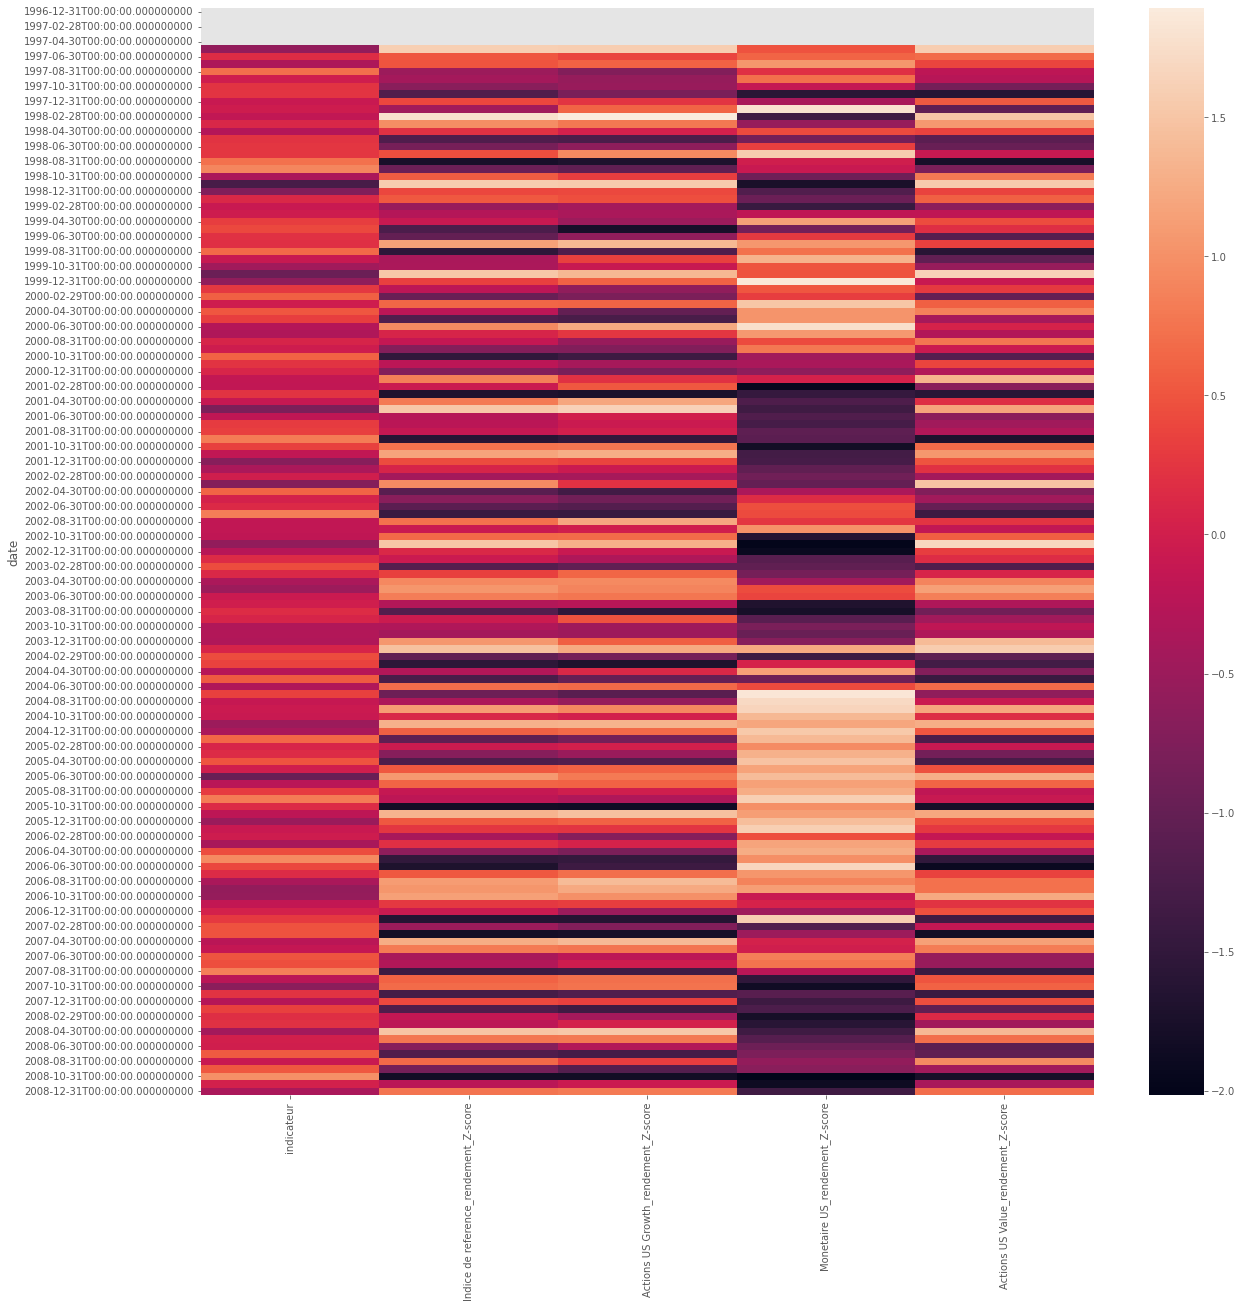

In [30]:
plt.figure(figsize=(20,20))
sns.heatmap(pd.merge(indicateur,score[['Indice de reference_rendement_Z-score','Actions US Growth_rendement_Z-score','Monetaire US_rendement_Z-score','Actions US Value_rendement_Z-score']],right_index=True, left_index=True,how="inner")[:"2008"])
plt.show()



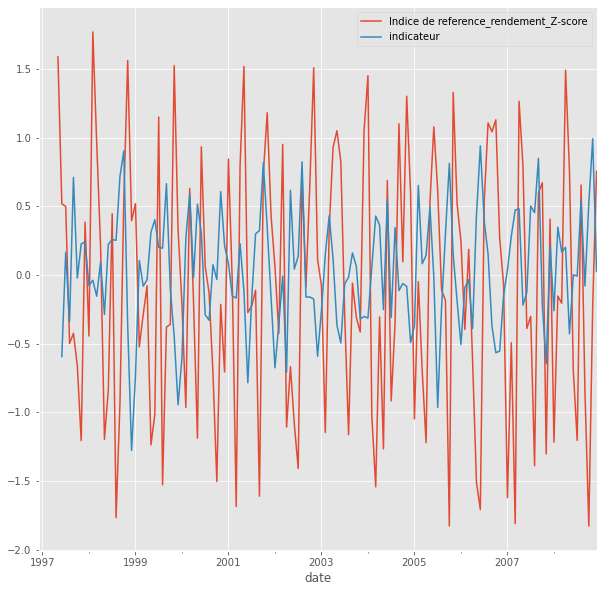

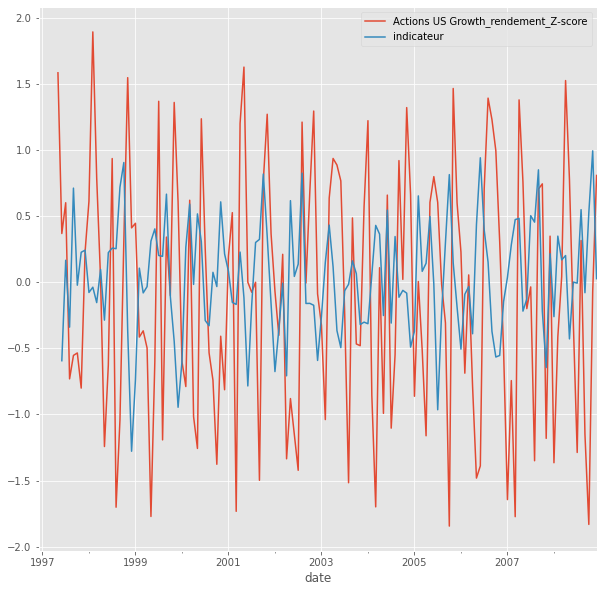

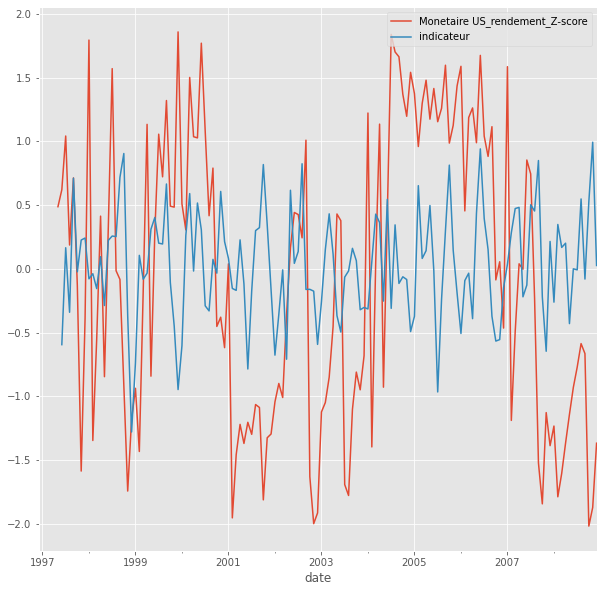

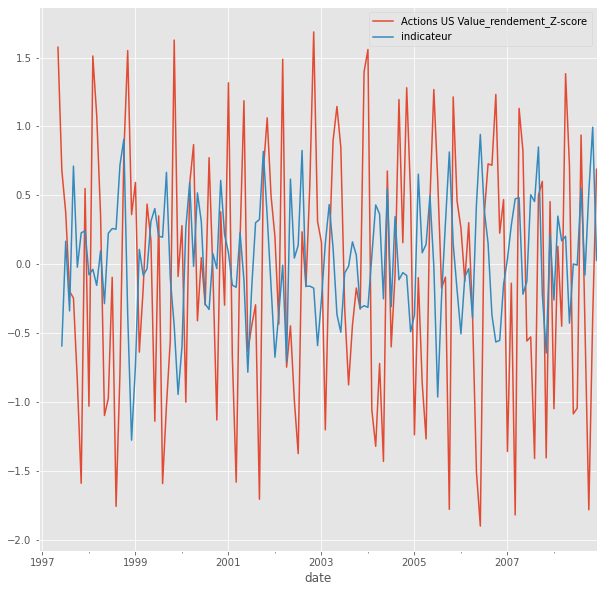

In [31]:
pd.merge(indicateur,score[['Indice de reference_rendement_Z-score','Actions US Growth_rendement_Z-score','Monetaire US_rendement_Z-score','Actions US Value_rendement_Z-score']],right_index=True, left_index=True,how="inner")[:"2008"].corr()
for col in['Indice de reference_rendement_Z-score','Actions US Growth_rendement_Z-score','Monetaire US_rendement_Z-score','Actions US Value_rendement_Z-score']:
   
    plt.figure(figsize=(10,10))
    pd.merge(indicateur,score[['Indice de reference_rendement_Z-score','Actions US Growth_rendement_Z-score','Monetaire US_rendement_Z-score','Actions US Value_rendement_Z-score']],right_index=True, left_index=True,how="inner")[:"2008"][col].plot()
    pd.merge(indicateur,score[['Indice de reference_rendement_Z-score','Actions US Growth_rendement_Z-score','Monetaire US_rendement_Z-score','Actions US Value_rendement_Z-score']],right_index=True, left_index=True,how="inner")[:"2008"]['indicateur'].shift(periods=1).plot()

    plt.legend()
    plt.show()




Donc nous allons tester la stratégie suivante: 

- Quand l'indicateur est au dessus de zéros, on investit tout dans Monétaire_us(poids=1)
- Quand l'indicateur est en dessous de zéros, on investit dans Action US Growth(poids=0.7), Action US Value(poids=0.25) 

In [32]:
poids_Action_US_Growth=pd.DataFrame({'poids_Action_US_Growth':np.where(indicateur.shift(periods=1).to_numpy()<0,0.7,0).reshape(265)},index=score.index)
poids_Action_US_Value=pd.DataFrame({'poids_Action_US_Value':np.where(indicateur.shift(periods=1).to_numpy()<0,0.3,0).reshape(265)},index=score.index)

poids_Monetaire_US=pd.DataFrame({'poids_US_Monetaire':np.where(indicateur.shift(periods=1).to_numpy()<0,0,1).reshape(265)},index=score.index)

indic_poids=pd.merge(indicateur,poids_Action_US_Growth,how='inner',left_index=True, right_index=True)
indic_poids=pd.merge(indic_poids,poids_Action_US_Value,how='inner',left_index=True, right_index=True)
indic_poids=pd.merge(indic_poids,poids_Monetaire_US,how='inner',left_index=True, right_index=True)
indic_poids



,indicateur,poids_Action_US_Growth,poids_Action_US_Value,poids_US_Monetaire
date,,,,
1996-12-31,NaN,0.0,0.0,1
1997-01-31,NaN,0.0,0.0,1
1997-02-28,NaN,0.0,0.0,1
1997-03-31,NaN,0.0,0.0,1
1997-04-30,NaN,0.0,0.0,1
...,...,...,...,...
2018-08-31,0.082695,0.7,0.3,0
2018-09-30,0.158905,0.0,0.0,1
2018-10-31,0.531993,0.0,0.0,1


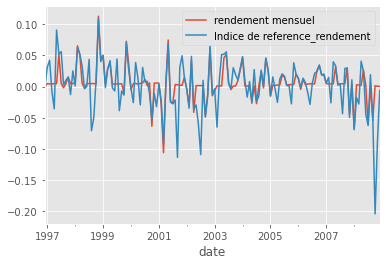

In [33]:
np.where(indicateur.to_numpy()>0,1,0).reshape(265)
rendement_mensuel=pd.DataFrame({"rendement mensuel":np.array(poids_Monetaire_US).reshape(265)*np.array(data_rendement["Monetaire US_rendement"])+np.array(poids_Action_US_Growth).reshape(265)*np.array(data_rendement["Actions US Growth_rendement"])+np.array(poids_Action_US_Value).reshape(265)*np.array(data_rendement["Actions US Value_rendement"])},index=score.index)
rendement_mensuel=pd.merge(rendement_mensuel,data_rendement['Indice de reference_rendement'],how='inner',left_index=True, right_index=True)

plt.figure()
for col in rendement_mensuel.columns:

    rendement_mensuel[col][:"2008"].plot()
    plt.legend()
plt.show()
    #data_rendement

In [34]:
ratio=np.where(rendement_mensuel["rendement mensuel"][:"2008"] >rendement_mensuel["Indice de reference_rendement"][:"2008"],
         True, False)

np.count_nonzero(ratio)/ratio.shape[0]

0.4827586206896552

On arrive a être rentable la majeure partie du temps, cependant nous subissons quand même deux creux qui cause des pertes.
Il faudrait désormais observé la rentabilité sur l'année et non sur les trimestres.
On constate aussi que de manière générale les 2 indices subissent des perte simultanément et on des gains similaires.  
**Surperformance de 61% sur les rendements trimestriels**

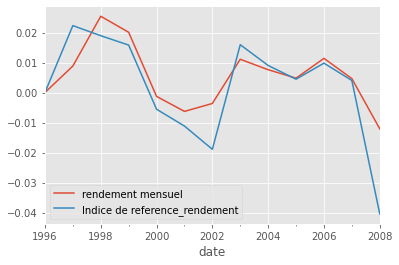

In [35]:
plt.figure()
for col in rendement_mensuel.columns:
    rendement_mensuel[col].resample('Y').mean()[:"2008"].plot()
    plt.legend()
plt.show()



In [36]:


ratio=np.where(rendement_mensuel.resample('Y').mean()["rendement mensuel"][:"2008"] >rendement_mensuel.resample('Y').mean()["Indice de reference_rendement"][:"2008"],
         True, False)

np.count_nonzero(ratio)/ratio.shape[0]

0.6923076923076923

Cette fois-ci on constate que les gains permet de compenser les pertes au sein d'une année.  
Désormais compararons nos résultats avec ce de l'indice initial.  
On remarque que notre indice superforme sur l'indice de référence sur les rendements à l'année la majeur partie du temps.  
**Superperformance de 69% sur les rendements annuels.**




Les poids attribuer en fonction des données in sample donne de bon résultats.

### OUT Sample 

Testons désormais cette stratégie sur les données de 2009 à 2018.

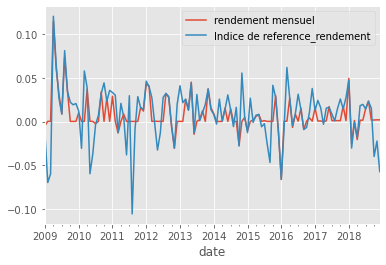

In [37]:
plt.figure()
for col in rendement_mensuel.columns:

    rendement_mensuel[col]["2009":].plot()
    plt.legend()
plt.show()

In [38]:
ratio=np.where(rendement_mensuel["rendement mensuel"]["2009":] >rendement_mensuel["Indice de reference_rendement"]["2009":],
         True, False)

np.count_nonzero(ratio)/ratio.shape[0]

0.48333333333333334

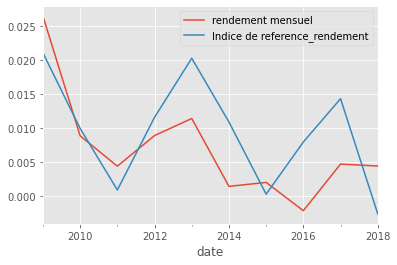

In [39]:
plt.figure()
for col in rendement_mensuel.columns:
    rendement_mensuel[col].resample('Y').mean()["2009":].plot()
    plt.legend()
plt.show()


In [40]:

ratio=np.where(rendement_mensuel.resample('Y').mean()["rendement mensuel"]["2009":] >rendement_mensuel.resample('Y').mean()["Indice de reference_rendement"]["2009":],
         True, False)

np.count_nonzero(ratio)/ratio.shape[0]

0.4

In [41]:
pd.DataFrame({'temps de surperformence du rendement mensuel en pourcentage':['48%','48%'],"temps de surperformence du rendement moyenne annuel en pourcentage":['68%','40%']},index=['in sample','out sample'])
                                                                                                                            
                                                                                                                            
                                                                                                                            
                                                                                                                            
                                                                                                                            

,temps de surperformence du rendement mensuel en pourcentage,temps de surperformence du rendement moyenne annuel en pourcentage
in sample,48%,68%
out sample,48%,40%


##  Exportant les données attendu


In [42]:
data_final=pd.merge(data_month, s, left_index=True, right_index=True,how='inner')
data_final=pd.merge(data_final, d, left_index=True, right_index=True,how='inner')
data_final=pd.merge(data_final, data_composite, left_index=True, right_index=True,how='inner')
#data_final=pd.merge(data_final, data['Indice de reference'], left_index=True, right_index=True,how='inner')

comp=['UNEMPLOY','PAYEMS','UMCSENT','RHEACBW027SBOG.csv','BAMLC0A4CBBB.csv','VIX','NASDAQCOM.csv','EMVOVERALLEMV','WM1NS']

composite=data_final[comp]

def rendement(data):
    s0=data.shift(periods=1)
    s0[0]=s0[1]
    S_t= np.array(data)
    return (S_t-s0)/s0

i=0
for col in composite.columns:
    if i==0:
        data_rendement=pd.DataFrame({col+"_rendement":rendement(composite[col])},index=composite.index)
        i+=1
    else:
        data_rendement=pd.merge(data_rendement,pd.DataFrame({col+"_rendement":rendement(composite[col])},index=composite.index),right_index=True,left_index=True,how='inner')
data_rendement[:"2008"].corr()
 
    
i=0
for col in data_rendement.columns:
    if i==0:
        score=pd.DataFrame({col+"_Z-score":Z_score(data_rendement[col])},index=data_rendement.index)
        i+=1
    else:
        score=pd.merge(score,pd.DataFrame({col+"_Z-score":Z_score(data_rendement[col])},index=data_rendement.index),right_index=True,left_index=True,how='inner')
score
        
for col in ['PAYEMS_rendement_Z-score','UMCSENT_rendement_Z-score','NASDAQCOM.csv_rendement_Z-score','WM1NS_rendement_Z-score']:
    score[col]=score[col]*-1
    

    
    
    
indicateur=score.mean(axis=1)#.drop(['Indice de reference_rendement_Z-score'],axis=1).mean(axis=1)

#indicateur=pd.DataFrame({'indicateur':np.average(score.drop(["Indice de reference_rendement_Z-score","Actions US Growth_rendement_Z-score","Monetaire US_rendement_Z-score","Actions US Value_rendement_Z-score"],
           #axis=1).to_numpy(),axis=1,weights=[0.05,0.05,0.1,0.1,0.2,0.5])},index=score.index)
           
indicateur=pd.DataFrame({"indicateur":indicateur},index=score.index)

#plt.figure()
#for col in ['Indice de reference_rendement_Z-score','indicateur']:
 #   pd.merge(indicateur,score['Indice de reference_rendement_Z-score'],right_index=True, left_index=True,how="inner")[col].plot()
  #  plt.legend()
#plt.show()

poids_Action_US_Growth=pd.DataFrame({'poids_Action_US_Growth':np.where(indicateur.shift(1).to_numpy()<0,0.7,0).reshape(316)},index=score.index)
poids_Action_US_Value=pd.DataFrame({'poids_Action_US_Value':np.where(indicateur.shift(1).to_numpy()<0,0.3,0).reshape(316)},index=score.index)

poids_Monetaire_US=pd.DataFrame({'poids_US_Monetaire':np.where(indicateur.shift(1).to_numpy()>0,1,0).reshape(316)},index=score.index)

indic_poids=pd.merge(indicateur,poids_Action_US_Growth,how='inner',left_index=True, right_index=True)
indic_poids=pd.merge(indic_poids,poids_Action_US_Value,how='inner',left_index=True, right_index=True)
indic_poids=pd.merge(indic_poids,poids_Monetaire_US,how='inner',left_index=True, right_index=True)
indic_poids.to_csv('indic_poids.csv')